# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
# global variables
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
img_short_side_resize = 256
img_input_size = 224
batch_size = 20
num_workers = 0

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


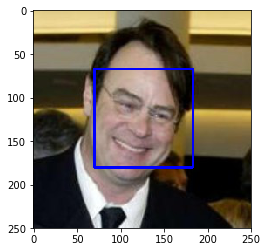

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

The percentage of detect face in human_files:98%

The percentage of detect face in dog_files:17%

In [5]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

def face_detection_test(files):
    face_cnt, total_cnt = 0, len(files)
    for file in tqdm(files):
        if face_detector(file) == True:
            face_cnt += 1
    return face_cnt, total_cnt

human_cnt, human_total = face_detection_test(human_files_short)
dog_cnt, dog_total = face_detection_test(dog_files_short)

print("The percentage of detect face in human_files:{0:.0%}".format(human_cnt / human_total))
print("The percentage of detect face in dog_files:{0:.0%}".format(dog_cnt / dog_total))

100%|██████████| 100/100 [00:30<00:00,  3.29it/s]

The percentage of detect face in human_files:98%
The percentage of detect face in dog_files:17%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [6]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [30]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [37]:
from PIL import Image
import torchvision.transforms as transforms


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img = Image.open(img_path).convert('RGB')

    in_transform = transforms.Compose([
                   transforms.Resize(img_input_size),
                   transforms.CenterCrop(img_input_size),
                   transforms.ToTensor(),
                   transforms.Normalize(norm_mean, norm_std)])
    
    img = in_transform(img).unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
    
    prediction = VGG16(img)
    
    return torch.max(prediction,1)[1].item() # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [42]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    idx = VGG16_predict(img_path)
    if idx >= 151 and idx <= 268:
        return True
    else:
        return False
    

In [43]:
print(dog_detector(dog_files_short[0]))
print(dog_detector(human_files_short[0]))

True
False


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

The percentage of detect a dog in human_files by VGG16: 3%

The percentage of detect a dog in dog_files by VGG16: 99%

In [44]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


def dog_detection_test(files):
    dog_cnt, total_cnt = 0, len(files)
    for file in tqdm(files):
        if dog_detector(file) == True:
            dog_cnt += 1
    return dog_cnt, total_cnt

human_cnt, human_total = dog_detection_test(human_files_short)
dog_cnt, dog_total = dog_detection_test(dog_files_short)


print('VGG-16 Prediction')
print("The percentage of detect a dog in human_files by VGG16: {0:.0%}".format(human_cnt / human_total))
print("The percentage of detect a dog in dog_files by VGG16: {0:.0%}".format(dog_cnt / dog_total))


100%|██████████| 100/100 [00:04<00:00, 25.26it/s]

VGG-16 Prediction
The percentage of detect a dog in human_files by VGG16: 0%
The percentage of detect a dog in dog_files by VGG16: 100%


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [45]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [46]:
import os
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

data_directory = '/data/dog_images/'
train_directory = os.path.join(data_directory, 'train/')
valid_directory = os.path.join(data_directory, 'valid/')
test_directory = os.path.join(data_directory, 'test/')

In [47]:
data_transforms = {'train': transforms.Compose([
                                     transforms.Resize(img_short_side_resize),
                                     transforms.RandomResizedCrop(img_input_size),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=norm_mean, std=norm_std)]),
                   'valid': transforms.Compose([
                                     transforms.Resize(img_short_side_resize),
                                     transforms.CenterCrop(img_input_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=norm_mean, std=norm_std)]),
                   'test': transforms.Compose([
                                     transforms.Resize(img_short_side_resize),
                                     transforms.CenterCrop(img_input_size),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=norm_mean, std=norm_std)])
                  }

# Create loaders for each dataset.
data_loaders = {'train': torch.utils.data.DataLoader(datasets.ImageFolder(train_directory, transform = data_transforms['train']),
                         batch_size = batch_size, num_workers = num_workers, shuffle=True),
                'valid': torch.utils.data.DataLoader(datasets.ImageFolder(valid_directory, transform = data_transforms['valid']),
                         batch_size = batch_size, num_workers=num_workers, shuffle=False),
                'test': torch.utils.data.DataLoader(datasets.ImageFolder(test_directory, transform = data_transforms['test']),
                        batch_size=batch_size, num_workers=num_workers, shuffle=False)
                }

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

The image are resize to 256 and then crop into 244.  I augmented the dataset by flipping the image horizontally and normalized from -1 to 1 as it is zero center. 


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
ImageFile.LOAD_TRUNCATED_IMAGES = True

# define the CNN architecture
num_classes = 133
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7*256, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
    
        x = x.view(x.size(0), -1)  # flatten
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.3)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

My architecture is based from the VGG16, 3 convolution layer with relu activation and max pool.  Then 2 fully connected layer into 133 class.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [49]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr = 0.05)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [50]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    if last_validation_loss is not None:
        valid_loss_min = last_validation_loss
    else:
        valid_loss_min = np.Inf
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            
            optimizer.zero_grad()  # initialize weights to zero
            
            output = model(data)
            
            
            loss = criterion(output, target) # calculate loss
            loss.backward() # back prop
            optimizer.step() # grad
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
    
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss
            
    # return trained model
    return model


# train the model
from workspace_utils import active_session

with active_session():
    model_scratch = train(20, data_loaders, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch 1, Batch 1 loss: 4.870891
Epoch 1, Batch 101 loss: 4.883960
Epoch 1, Batch 201 loss: 4.879807
Epoch 1, Batch 301 loss: 4.872288
Epoch: 1 	Training Loss: 4.868833 	Validation Loss: 4.780007
Validation loss decreased (inf --> 4.780007).  Saving model ...
Epoch 2, Batch 1 loss: 4.846978
Epoch 2, Batch 101 loss: 4.746792
Epoch 2, Batch 201 loss: 4.714894
Epoch 2, Batch 301 loss: 4.701316
Epoch: 2 	Training Loss: 4.693514 	Validation Loss: 4.505741
Validation loss decreased (4.780007 --> 4.505741).  Saving model ...
Epoch 3, Batch 1 loss: 4.779426
Epoch 3, Batch 101 loss: 4.596449
Epoch 3, Batch 201 loss: 4.603254
Epoch 3, Batch 301 loss: 4.600554
Epoch: 3 	Training Loss: 4.601622 	Validation Loss: 4.432245
Validation loss decreased (4.505741 --> 4.432245).  Saving model ...
Epoch 4, Batch 1 loss: 4.263486
Epoch 4, Batch 101 loss: 4.517219
Epoch 4, Batch 201 loss: 4.538240
Epoch 4, Batch 301 loss: 4.524163
Epoch: 4 	Training Loss: 4.522371 	Validation Loss: 4.349154
Validation loss de

In [51]:
# model_scratch = torch.load('model_scratch.pt')
# model_scratch.eval()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [52]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        
        output = model(data) # feedfoward
        loss = criterion(output, target) # calculate loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss)) # update average test loss
        pred = output.data.max(1, keepdim=True)[1] # predicted output possbilities
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy()) # compare predictions to true value
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
with active_session():
    test(data_loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.507183


Test Accuracy: 15% (132/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [53]:
## TODO: Specify data loaders

loaders_transfer = data_loaders.copy()

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [54]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.vgg16(pretrained=True)

# Freeze the pre-trained weights
for param in model_transfer.features.parameters():
    param.required_grad = False
    

n_inputs = model_transfer.classifier[6].in_features # Get the input of the last layer of VGG-16
last_layer = nn.Linear(n_inputs, 133)  # set the new layer with 133 classes and set autograd to be true
model_transfer.classifier[6] = last_layer # modify the last layer to the new layer.

print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I load the pre-trained vgg16 model.  Then freeze the pre-trained weights.

The get the input of the last fully-connected layer of VGG-16 of 133 classes.
The new layer automatically has requires_grad = True to train the parameters
VGG has a very high accuracy, so I chose VGG-16


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [55]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [56]:
# train the model
n_epochs = 20
with active_session():
    model_transfer = train(n_epochs, loaders_transfer, model_transfer, 
                           optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best valid accuracy 
model_transfer.load_state_dict(torch.load('model_transfer.pt'))




Epoch 1, Batch 1 loss: 5.242754
Epoch 1, Batch 101 loss: 4.804532
Epoch 1, Batch 201 loss: 4.553841
Epoch 1, Batch 301 loss: 4.321213
Epoch: 1 	Training Loss: 4.241830 	Validation Loss: 2.826425
Validation loss decreased (inf --> 2.826425).  Saving model ...
Epoch 2, Batch 1 loss: 3.452360
Epoch 2, Batch 101 loss: 3.148935
Epoch 2, Batch 201 loss: 2.951210
Epoch 2, Batch 301 loss: 2.734423
Epoch: 2 	Training Loss: 2.677741 	Validation Loss: 1.250224
Validation loss decreased (2.826425 --> 1.250224).  Saving model ...
Epoch 3, Batch 1 loss: 1.845269
Epoch 3, Batch 101 loss: 1.957351
Epoch 3, Batch 201 loss: 1.893655
Epoch 3, Batch 301 loss: 1.798625
Epoch: 3 	Training Loss: 1.779885 	Validation Loss: 0.750847
Validation loss decreased (1.250224 --> 0.750847).  Saving model ...
Epoch 4, Batch 1 loss: 1.204389
Epoch 4, Batch 101 loss: 1.518919
Epoch 4, Batch 201 loss: 1.499137
Epoch 4, Batch 301 loss: 1.480283
Epoch: 4 	Training Loss: 1.463402 	Validation Loss: 0.577288
Validation loss de

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [57]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.410718


Test Accuracy: 87% (734/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [58]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
from PIL import Image
import torchvision.transforms as transforms

class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
loaders_transfer['train'].dataset.classes[:10]
class_names[:10]

def predict_breed_transfer(model, class_names, img_path):

    img = Image.open(img_path).convert('RGB')
    prediction_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean = norm_mean, std = norm_std)])    
    img = prediction_transform(img)[:3,:,:].unsqueeze(0) 

    model = model.cpu()
    model.eval()    
    idx = torch.argmax(model(img))    
    return class_names[idx]

for img_file in os.listdir('/data/dog_images/test/076.Golden_retriever/'):
    img_path = os.path.join('/data/dog_images/test/076.Golden_retriever/', img_file)    
    predition = predict_breed_transfer(model_transfer, class_names, img_path)
    print("image_fname: {0}, \t pred breed: {1}".format(img_path, predition))

image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05258.jpg, 	 pred breed: Golden retriever
image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05234.jpg, 	 pred breed: Golden retriever
image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05221.jpg, 	 pred breed: Golden retriever
image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05248.jpg, 	 pred breed: Golden retriever
image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05240.jpg, 	 pred breed: Dachshund
image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05241.jpg, 	 pred breed: Golden retriever
image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05220.jpg, 	 pred breed: Golden retriever
image_fname: /data/dog_images/test/076.Golden_retriever/Golden_retriever_05250.jpg, 	 pred breed: Golden retriever


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

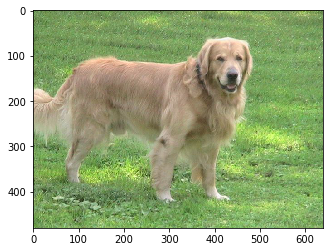

Dogs Detected!  You are Golden retriever


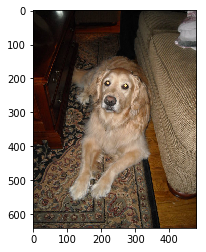

Dogs Detected!  You are Golden retriever


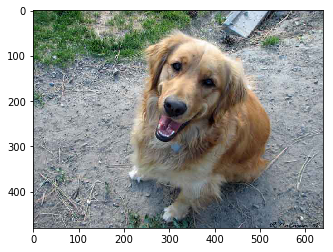

Dogs Detected!  You are Golden retriever


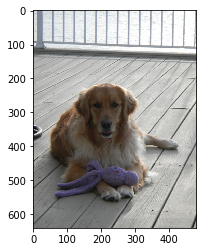

Dogs Detected!  You are Golden retriever


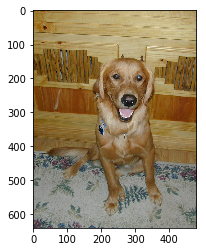

Dogs Detected!  You are Dachshund


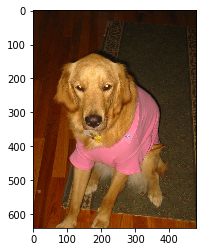

Dogs Detected!  You are Golden retriever


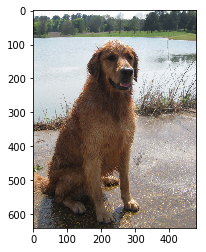

Dogs Detected!  You are Golden retriever


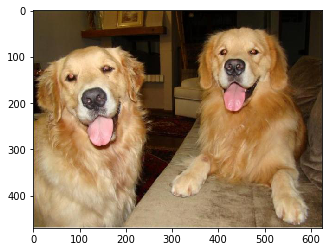

Dogs Detected!  You are Golden retriever


In [59]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    
    if dog_detector(img_path) is True:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Dogs Detected!  You are {0}".format(prediction))  
    elif face_detector(img_path) > 0:
        prediction = predict_breed_transfer(model_transfer, class_names, img_path)
        print("Human Detected!  But you look like a {0}".format(prediction))
    else:
        print("Error! You are neither human nor dog!")
        
for img_file in os.listdir('/data/dog_images/test/076.Golden_retriever/'):
    img_path = os.path.join('/data/dog_images/test/076.Golden_retriever/', img_file)
    run_app(img_path)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

I used some robot dog image, and dummie human image to test the result.  The model cannot determinate if the it is dog or human.

The output is close to what I expected!!!  and it's very accurate.

The 3 possible points of improvement for the algorithms.
- Increase the training dataset for each breed, each bread has about less than 10 image.  If we can increase to 50 to each breed, the accuracy should be increased.
- Try to compare performance among models and use grid search to find the optimal hyperparameter.
- For the face detection, we can use other face detection method, such as CNN


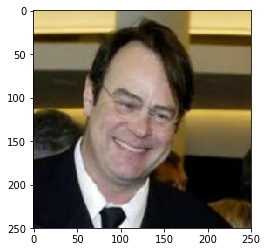

Human Detected!  But you look like a American foxhound


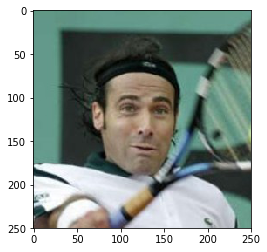

Human Detected!  But you look like a Dachshund


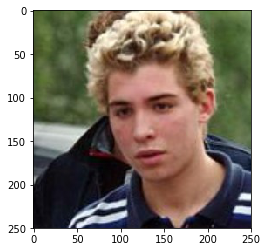

Human Detected!  But you look like a Portuguese water dog


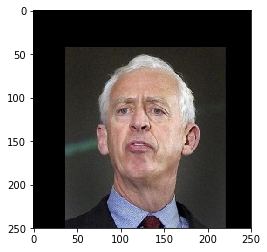

Human Detected!  But you look like a Brittany


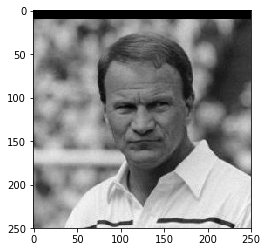

Human Detected!  But you look like a Smooth fox terrier


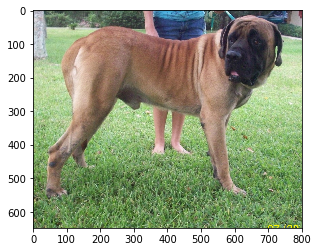

Dogs Detected!  You are Bullmastiff


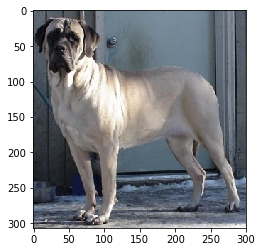

Dogs Detected!  You are Mastiff


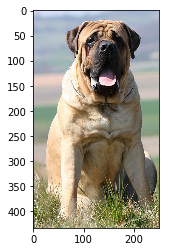

Dogs Detected!  You are Bullmastiff


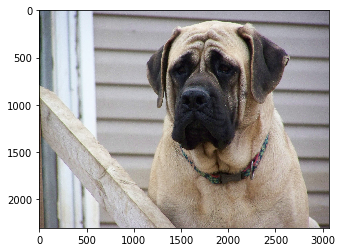

Dogs Detected!  You are Mastiff


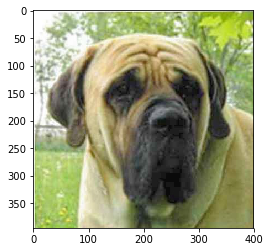

Dogs Detected!  You are Mastiff


In [60]:
# Test!
for file in np.hstack((human_files[:5], dog_files[:5])):
    run_app(file)

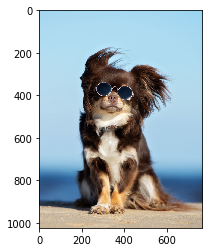

Dogs Detected!  You are Australian shepherd


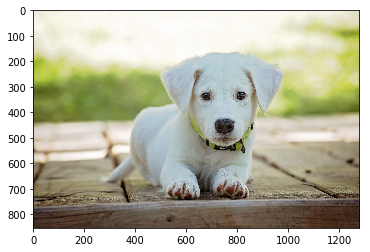

Dogs Detected!  You are Parson russell terrier


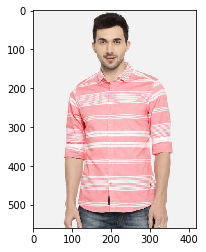

Human Detected!  But you look like a Dachshund


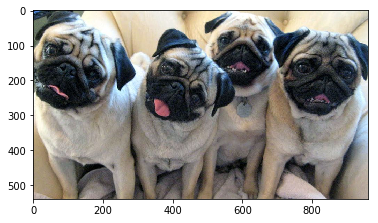

Dogs Detected!  You are Bulldog


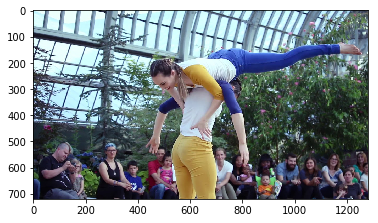

Human Detected!  But you look like a Bull terrier


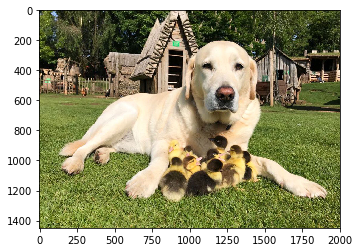

Dogs Detected!  You are Labrador retriever


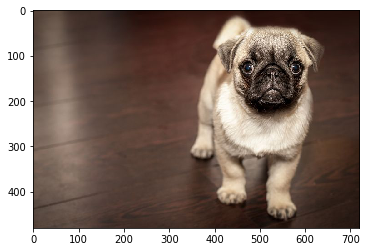

Dogs Detected!  You are Pekingese


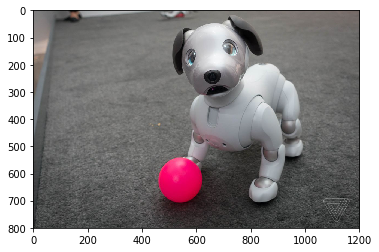

Error! You are neither human nor dog!


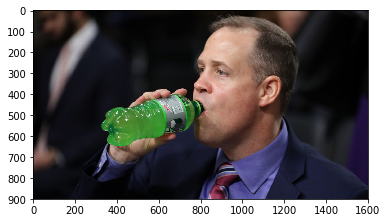

Error! You are neither human nor dog!


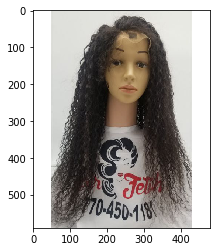

Human Detected!  But you look like a Cocker spaniel


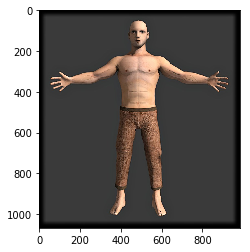

Human Detected!  But you look like a Chinese crested


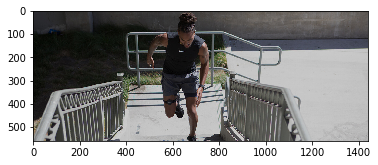

Human Detected!  But you look like a Chinese crested


In [61]:

## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
example_files = np.array(glob("test_dataset/*"))
## suggested code, below
for file in np.hstack(example_files):
    run_app(file)